# Introduction

This is a solution to the BGI test on cell clustering, by Vladimir Goryachev.

I implement the algorithm for clustering proposed in the test, with two ways of resolving inconsistensies. I visualise their outputs for several thresholding values. I also use hierarchical clustering on the data and visualise its results as well.

To reproduce my results, please upload the file `E14.5_E1S3_Dorsal_Midbrain_GEM_CellBin_merge.tsv` to the Google Colab files of this notebook.

# Reading the data

In [1]:
import pandas as pd
df = pd.read_csv('/content/E14.5_E1S3_Dorsal_Midbrain_GEM_CellBin_merge.tsv', sep='\t')
df.head()

,geneID,x,y,MIDCounts,cell
0,Arpc1b,19881,9379,3,170675
1,B230118H07Rik,19881,9379,2,170675
2,Bcl2l12,19881,9379,1,170675
3,Ccnd3,19881,9379,1,170675
4,Cdk8,19881,9379,3,170675


# Preprocessing

Identifiers for genes are strings, and identifiers for cells are some integers starting with 170675. For ease of use, I encode both those columns with integers starting from zero.

Then I create a COOrdinate sparse matrix. The encodings of cells and genes serve as coordinates, and gene expression counts serve as values.

I consider it important to use sparse matrix representation in this case, rather than dense, as less than 2% of cells of the dense matrix would have been filled.



In [2]:
import numpy as np
from scipy.sparse import coo_matrix

df['geneID_n'], geneID_labels = df['geneID'].factorize()
df['cell_n'], cell_labels = df['cell'].factorize()

geneID_n = df['geneID_n']
cell_n = df['cell_n']
MIDCounts = df['MIDCounts']

sparse_matrix = coo_matrix((MIDCounts, (cell_n, geneID_n)))
sparse_matrix

<4872x18698 sparse matrix of type '<class 'numpy.int64'>'
	with 1656407 stored elements in COOrdinate format>

I have decided to use UMAP for performing the projection of the matrix. I did not use PCA because it does not accept sparce matrices for input, at least in the scikit-learn implementation. I tried to used t-SNE, but it took about three times longer than UMAP to run (6 minutes vs 2 minutes).

In [3]:
#from sklearn.manifold import TSNE
#tsne_model = TSNE(n_components=2)

# Use the fit_transform method to project the COO matrix onto a lower-dimensional space using t-SNE
#projected_matrix = tsne_model.fit_transform(sparse_matrix)

In [4]:
!pip install umap-learn
import umap
umap_model = umap.UMAP(n_components=2)
projected_matrix = umap_model.fit_transform(sparse_matrix)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


I scale the data obtained from projection, so that it fits into the range for the x coordinate. An alternative option could be to scale one projection coordinate with respect to x, and the other with respect to y. However, scaling the projecion coordinates by different parameters would distort the projection, giving one of the factors more significance than appropriate.

While I was asked by the task to scale the data in this particular way, I personally find it more sensible to scale all the data to the values between 0 and 1 (taking care not to distort the ratio of x to y).

In [5]:
u = projected_matrix[:, 0]
v = projected_matrix[:, 1]
u_min, u_max = u.min(), u.max()
v_min, v_max = v.min(), v.max()
x_min, x_max = df.x.min(), df.x.max()
y_min, y_max = df.y.min(), df.y.max()
u = (u - u_min)*(x_max-x_min)/(u_max-u_min) + x_min
v = (v - v_min)*(x_max-x_min)/(v_max-v_min) + x_min

Then I create a dataframe indexed by unique cells. For each cell, I store all the information relevant for clustering: gene expression projections, and spatial coordinates. I obtain the spatial coordinates by averaging the spatial coordinates of all the gene expression events registered in this cell.

In [6]:
df_cells = pd.DataFrame(np.array([u, v]).transpose())
df_cells.index = cell_labels
df_cells.columns = ['genes_0', 'genes_1']
averages_x = df.groupby("cell")["x"].mean()
df_cells["x"] = averages_x
averages_y = df.groupby("cell")["y"].mean()
df_cells["y"] = averages_y

# Clustering

For clustering, I first obtain the pairwise distance matrices for al the cells. As the number of cells is relatively low (less than 5000), it is feasible to simply precompute and store the pairwise distance matrices.

In [7]:
from sklearn.metrics.pairwise import pairwise_distances

exp_distance = pairwise_distances(df_cells[['genes_0', 'genes_1']])
spa_distance = pairwise_distances(df_cells[['x', 'y']])

Then I define a function for performing cell clustering according to the method described in the test paper.

I iterate over all the cells, and for each cell I try to find an existing cluster within the threshold distance towards the cell. If I find it, I add the cell to this cluster. If I do not find it, I create a new cluster and the cell there. In the end, I record the information about clusters in a single array. I measure the distance between a cell and a cluster as the least distance between the new cell and any cluster cell.

The test ask me to "Resolve any potential collision or inconsistency in a logical way". The main inconsistency I find here is that "cells lie within threshold distance of each other" is an inherently non-transitive relationship: For cells A, B and C, cells A and B can lie withtin this distance to each other, as well as B and C, but not A and C. 

In practice, this problem manifests in the fact that a new cell can lie close enough to several different clusters. I implement two ways to resolve it, using the boolean parameter `agg` (abbreviation from aggregate) to switch between them. The first method is the most naive one: just add the cell to the first cluster it is close enough to. The second method is to merge all the clusters which the new cell is close enough to, and to add the cell to this new cluster. Alternative options I have not tried are choosing the closest cluster or a random cluster from the clusters which are close enough.

In [8]:
def MyClustering(agg = True, exp_weight = 0.8, percentage_distance_thr = 0.02):

    total_distance = exp_distance * exp_weight + spa_distance * (1 - exp_weight)
    max_total_distance = total_distance.max()
    cluster_threshold = percentage_distance_thr * max_total_distance

    clusters = []
    for i, cell in df_cells.reset_index().iterrows():
        in_cluster = False
        current_clusters = []
        for ic, cluster in enumerate(clusters):
            
            for j in cluster:
                if total_distance[i, j] < cluster_threshold:
                    cluster.append(i)
                    in_cluster = True
                    current_clusters.append(ic)
                    break
                if not agg:
                    break
        
        if agg and len(current_clusters) > 1:
            new_cluster = sum([clusters[i] for i in current_clusters], [])
            for index in sorted(current_clusters, reverse=True):
                del clusters[index]
            clusters.append(new_cluster)        
        
        if not in_cluster:
            clusters.append([i])

    answer = np.zeros(len(df_cells))
    for j, cluster in enumerate(clusters):
        for i in cluster:
            answer[i] = j
    return answer

Next, I plot the output of the clustering algortithm for several values of the threshold distance. I use expression weight equal to 0.8 everywhere, as varying both parameters would result in too many graphs. I have chosen this parameter because lower values mainly resulted in the cells being clustered into crosswise segments along the tissue, rather than into long strips as depicted in the ground truth picture. Higher values however tend to disregard the spatial position and produce very noisy images as a result.

Below you can see the images for clustering with aggregation turned on.

When the distance threshold is too low (0.01), the cells tend to form really small clusters. A gradient is visible, because cells are stored in such a way that they a processed from left to right. Because of that the cells on the left are added into clusters which form first, and cells on the right are added to the clusters which form last, resulting in a gradient.

When the distance threshold is too high (0.06), all the clusters aggregate into one super-cluster, and all the information is lost.

Visually, the most promising images seem to the ones with percetage thresholds of 2% and 3%. They seem to capture the thin and long clusters of cells along the edges of the tissue, and the ground truth image also features mainly longtitunal clusters of cells.

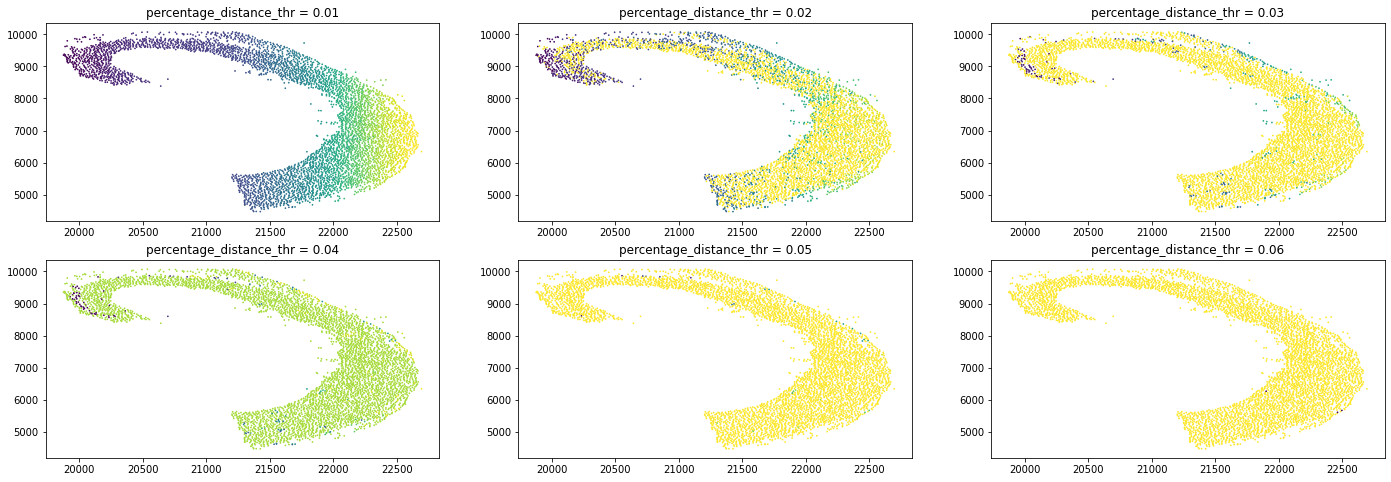

In [9]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3, figsize = (24, 8))
ptrs = [[0.01, 0.02, 0.03],
        [0.04, 0.05, 0.06]]
for i, ax_i in enumerate(axes):
    for j, ax in enumerate(ax_i):
        labels = MyClustering(percentage_distance_thr=ptrs[i][j])
        ax.scatter(df_cells.x, df_cells.y, c=labels, s=0.5)
        ax.set_title("percentage_distance_thr = " + str(ptrs[i][j]))

Here are the images for clustering with aggregation turned off. As you can see, as the quality of clustering is much lower, as there are sharp cutoffs in clusters based on x coordinates of cells, which is obviously unrealistic. This has to do with the cells being ordered left to right in the data. This could be countered with randomising the order in which cells are processed, but this would result in instability of an otherwise deterministic algorithm, so I have decided against it. 

Another point of interest is that much higher distance thresholds are appropriate here, as distant clusters never merge. As a result, thresholds as high as 10% and 20% produce pictures similar to the one obtained by the aggregating algorithm at only 1%.

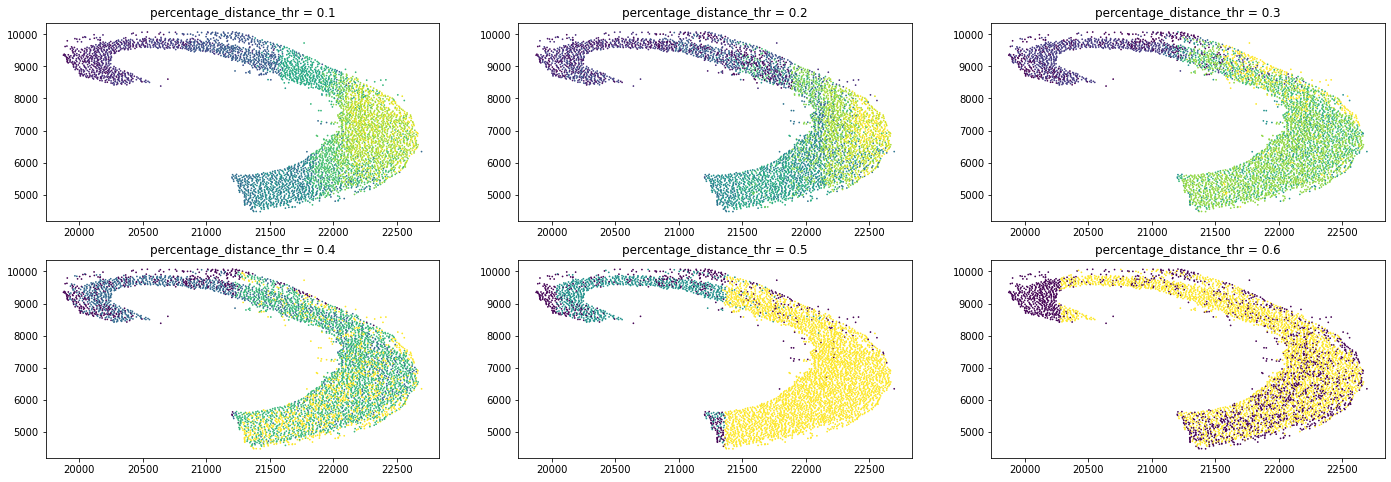

In [10]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(2, 3, figsize = (24, 8))
ptrs = [[0.1, 0.2, 0.3],
        [0.4, 0.5, 0.6]]
for i, ax_i in enumerate(axes):
    for j, ax in enumerate(ax_i):
        labels = MyClustering(percentage_distance_thr=ptrs[i][j], agg = False)
        ax.scatter(df_cells.x, df_cells.y, c=labels, s=0.5)
        ax.set_title("percentage_distance_thr = " + str(ptrs[i][j]))

For comparison, I have also tried to run the hierarchical clustering algorithm included with scikit-learn package. However, its results seem lacking: for expression weight of 0.8 it features very naive space-based clustering, and already at 0.85 it looks like random noise.

In [16]:
from sklearn.cluster import AgglomerativeClustering

def AggClusteringWrapper(exp_weight = 0.8, n_clusters = 5):
    total_distance = exp_distance * exp_weight + spa_distance * (1 - exp_weight)
    clusterer = AgglomerativeClustering(linkage='average', affinity='precomputed', n_clusters = n_clusters)
    clusterer.fit(total_distance)
    return clusterer.labels_

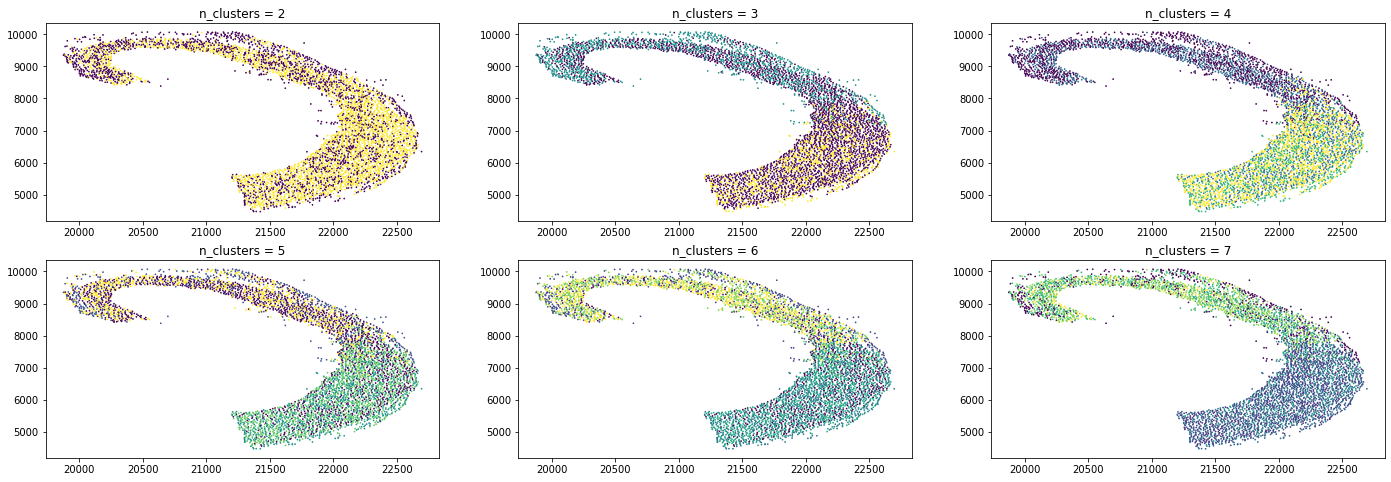

In [17]:
fig, axes = plt.subplots(2, 3, figsize = (24, 8))
for i, ax_i in enumerate(axes):
    for j, ax in enumerate(ax_i):
        labels = AggClusteringWrapper(n_clusters = 3*i + j +2)
        ax.scatter(df_cells.x, df_cells.y, c=labels, s=0.5)
        ax.set_title("n_clusters = " + str(3*i + j + 2))

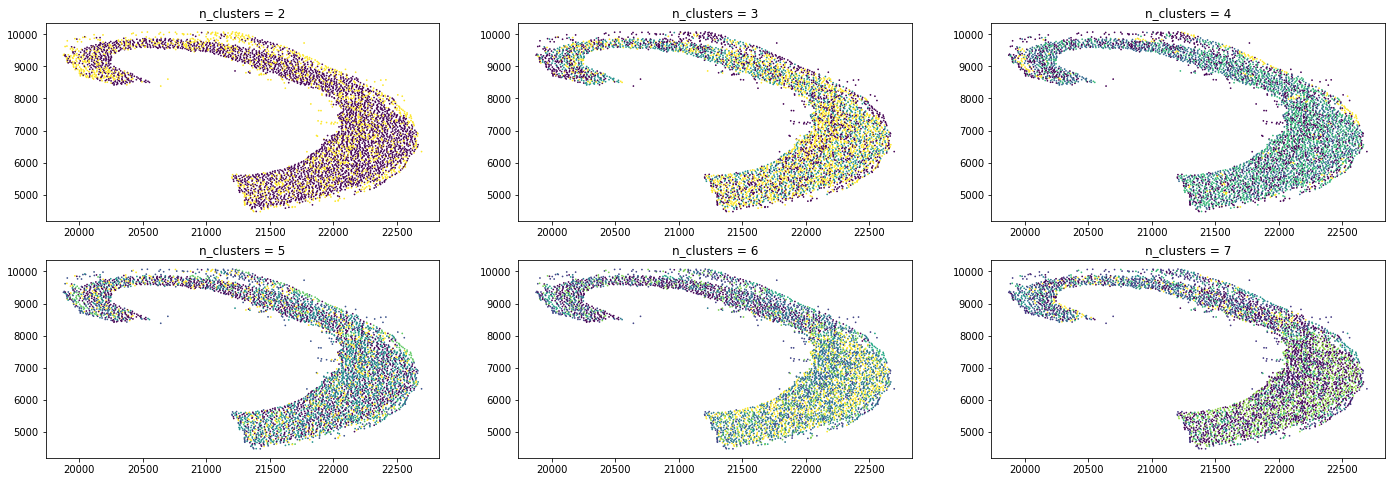

In [18]:
fig, axes = plt.subplots(2, 3, figsize = (24, 8))
for i, ax_i in enumerate(axes):
    for j, ax in enumerate(ax_i):
        labels = AggClusteringWrapper(n_clusters = 3*i + j +2, exp_weight = 0.85)
        ax.scatter(df_cells.x, df_cells.y, c=labels, s=0.5)
        ax.set_title("n_clusters = " + str(3*i + j + 2))

# Conclusion.

I have implemented two variations of a clustering algorithm, as well used an existing clustering algorithm. The most promising clustering was produced by the implemented algorithm with aggregation turned on, with expression weight of 0.8 and distance threshold of 2%. I save this clustering, as well as gene expression coordinates and spatial coordinates to be available as a CSV file.

In [23]:
df_cells["cluster"] = MyClustering(percentage_distance_thr=0.02)
df_cells.to_csv( "clustering_results.csv")